# Introduction

Here we give a brief introduction to `openscm_units`.

## The unit registry

``openscm_units.unit_registry`` extends Pint's default unit registry by adding simple climate modelling related units. We'll spare the details here (they can be found in [our documentation](https://openscm-units.readthedocs.io/en/latest/unit_registry.html)), but the short idea is that you can now do all sorts of simple climate modelling related conversions which were previously impossible.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback

import pandas as pd
import seaborn as sns
from pint.errors import DimensionalityError

from openscm_units import unit_registry

## Basics

``openscm_units.unit_registry`` knows about basic units, e.g. 'CO2'.

In [2]:
unit_registry("CO2")

1 <Unit('CO2')>

Standard conversions are now trivial.

In [3]:
unit_registry("CO2").to("C")

0.2727272727272727 <Unit('C')>

In [4]:
emissions_aus = 0.34 * unit_registry("Gt C / yr")
emissions_aus.to("Mt CO2/yr")

1246.666666666667 <Unit('CO2 * megametric_ton / a')>

## Contexts

In general, we cannot simply convert e.g. CO$_2$ emissions into CH$_4$ emissions. 

In [5]:
try:
    unit_registry("CH4").to("CO2")
except DimensionalityError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
pint.errors.DimensionalityError: Cannot convert from 'CH4' ([methane]) to 'CO2' ([carbon])


However, a number of metrics exist which do allow conversions between GHG species. Pint plus OpenSCM's inbuilt metric conversions allow you to perform such conversions trivially by specifying the `context` keywrod.

In [6]:
with unit_registry.context("AR4GWP100"):
    ch4_ar4gwp100_co2e = unit_registry("CH4").to("CO2")

ch4_ar4gwp100_co2e

25.0 <Unit('CO2')>

## Gas mixtures

Some gases (mainly, refrigerants) are actually mixtures of other gases, for example HFC407a (aka R-407A). In general, they can be used like any other gas. Additionally, `openscm_units` provides the ability to split these gases into their constituents.

In [7]:
emissions = 20 * unit_registry('kt HFC407a / year')

with unit_registry.context("AR4GWP100"):
    print(emissions.to('Gg CO2 / year'))

42140.0 CO2 * gigagram / year


In [8]:
unit_registry.split_gas_mixture(emissions)

[4.0 <Unit('HFC32 * kt / year')>,
 8.0 <Unit('HFC125 * kt / year')>,
 8.0 <Unit('HFC134a * kt / year')>]

## Building up complexity

`openscm_units` is meant to be a simple repository which does one thing, but does it well. We encourage you to use it wherever you like (and if you do please let us know via the [issue tracker](https://github.com/openscm/openscm-units/issues)). As an example of something we can do, we can quickly see how GWP100 has changed between assessment reports.

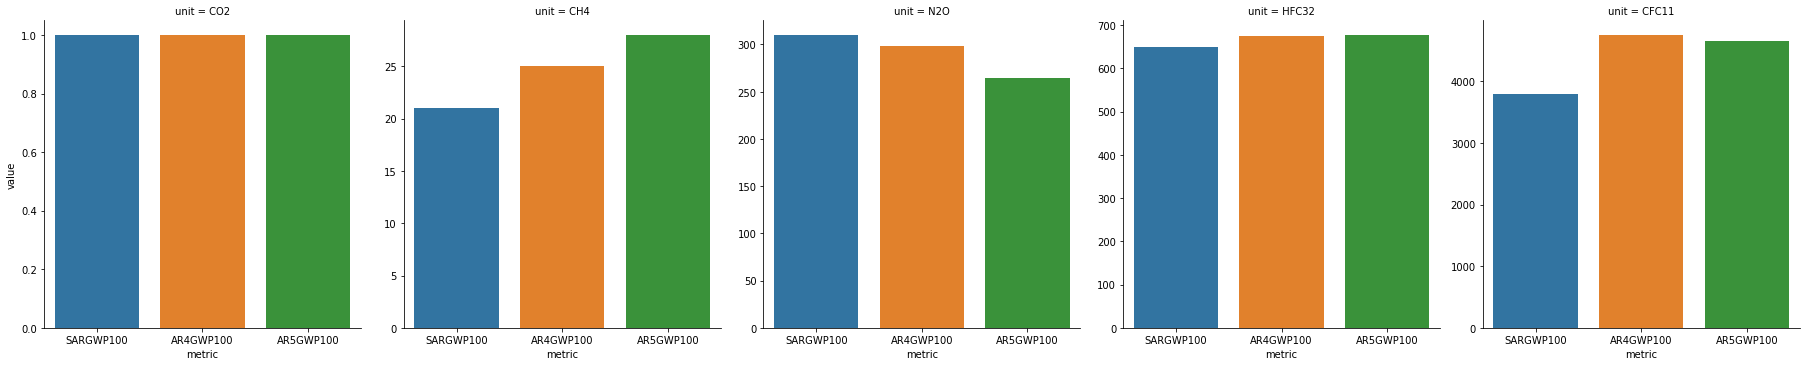

In [9]:
# NBVAL_IGNORE_OUTPUT
units_of_interest = ["CO2", "CH4", "N2O", "HFC32", "CFC11"]
metrics_of_interest = ["SARGWP100", "AR4GWP100", "AR5GWP100"]
data = {
    "unit": [],
    "metric": [],
    "value": [],
}
for metric in metrics_of_interest:
    with unit_registry.context(metric):
        for unit in units_of_interest:
            data["unit"].append(unit)
            data["metric"].append(metric)
            data["value"].append(unit_registry(unit).to("CO2").magnitude)

data = pd.DataFrame(data)

sns.catplot(
    data=data,
    x="metric",
    y="value",
    kind="bar",
    col="unit",
    col_wrap=5,
    sharey=False,
)